In [5]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import h5py
import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from common import CosmoInterpolator
import json

label_fontsize = 18
tick_fontsize = 18
title_fontsize = 18

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["figure.figsize"] = (4, 3)


In [6]:
cosmo = CosmoInterpolator()
h5_path = "so3_results.h5"
h5f = h5py.File(h5_path, "r")
h5f.keys()

<KeysViewHDF5 ['production_inference_m1=1000000.0_m2=10.0_a=0.99_e_f=0.01_T=1.0_z=1.5', 'production_inference_m1=1000000.0_m2=10.0_a=0.99_e_f=0.05_T=1.0_z=1.5', 'production_inference_m1=1000000.0_m2=50.0_a=0.99_e_f=0.01_T=1.0_z=1.5', 'production_inference_m1=1000000.0_m2=50.0_a=0.99_e_f=0.05_T=1.0_z=1.5', 'production_snr_m1=1000.0_m2=10.0_a=-0.99_e_f=1e-08_T=0.5_z=0.01', 'production_snr_m1=1000.0_m2=10.0_a=-0.99_e_f=1e-08_T=0.5_z=0.03499635511580584', 'production_snr_m1=1000.0_m2=10.0_a=-0.99_e_f=1e-08_T=0.5_z=0.12247448713915891', 'production_snr_m1=1000.0_m2=10.0_a=-0.99_e_f=1e-08_T=0.5_z=0.42861606445482003', 'production_snr_m1=1000.0_m2=10.0_a=-0.99_e_f=1e-08_T=0.5_z=1.5', 'production_snr_m1=1000.0_m2=10.0_a=0.0_e_f=1e-08_T=0.5_z=0.01', 'production_snr_m1=1000.0_m2=10.0_a=0.0_e_f=1e-08_T=0.5_z=0.03499635511580584', 'production_snr_m1=1000.0_m2=10.0_a=0.0_e_f=1e-08_T=0.5_z=0.12247448713915891', 'production_snr_m1=1000.0_m2=10.0_a=0.0_e_f=1e-08_T=0.5_z=0.42861606445482003', 'producti

In [25]:
# SNR FOM
processed_results = []
for source in h5f.keys():
    if 'snr' in source:
        m1 = h5f[source]['m1'][()]
        z = h5f[source]['redshift'][()]
        a = h5f[source]['a'][()]
        snr = h5f[source]["snr"][()]
        sky_loc = h5f[source]["sky_loc"][()]
        processed_results.append({'m1': np.round(m1, decimals=7), 'a': a, 'redshift': z, 'snr': snr, 'sky_loc': sky_loc})

# Convert to DataFrame for easier analysis
snr_results = pd.DataFrame(processed_results)
m1_list = np.unique(snr_results["m1"].to_numpy())
a_list = np.unique(snr_results["a"].to_numpy())
# print(m1_list, a_list)

# PE FOM
snr_threshold = 20
processed_results = []
for source in h5f.keys():
    if 'inference' in source:
        m1 = h5f[source]['m1'][()]
        m2 = h5f[source]['m2'][()]
        z = h5f[source]['redshift'][()]
        a = h5f[source]['a'][()]
        ef = h5f[source]["e_f"][()]
        snr = h5f[source]["snr"][()]
        sky_loc = h5f[source]["sky_loc"][()]
        
        snr_cut = snr > snr_threshold
        sky_loc = sky_loc[snr_cut]
        key_error_type = "error_source" # "error_detector" # 
        temp_ = {key: h5f[source][key][key_error_type][snr_cut] for key in h5f[source].keys() if "error" in key}
        print(f"Source {source} has {np.sum(snr_cut)} detections with SNR>{snr_threshold}.")
        processed_results.append({'m1': m1, 'm2': np.round(m2, decimals=7), 'a': a, 'ef': np.round(ef, decimals=7), 'redshift': z, 'snr': snr[snr_cut], 'sky_loc': sky_loc, **temp_})

pe_results = pd.DataFrame(processed_results)
m2_list = np.unique(pe_results["m2"].to_numpy())
ef_list = np.unique(pe_results["ef"].to_numpy())
# print(m2_list, ef_list)
pe_results.keys()

Source production_inference_m1=1000000.0_m2=10.0_a=0.99_e_f=0.01_T=1.0_z=1.5 has 492 detections with SNR>20.
Source production_inference_m1=1000000.0_m2=10.0_a=0.99_e_f=0.05_T=1.0_z=1.5 has 503 detections with SNR>20.
Source production_inference_m1=1000000.0_m2=50.0_a=0.99_e_f=0.01_T=1.0_z=1.5 has 952 detections with SNR>20.
Source production_inference_m1=1000000.0_m2=50.0_a=0.99_e_f=0.05_T=1.0_z=1.5 has 985 detections with SNR>20.


Index(['m1', 'm2', 'a', 'ef', 'redshift', 'snr', 'sky_loc',
       'absolute_errors_Omega', 'absolute_errors_a', 'absolute_errors_dist',
       'absolute_errors_e0', 'absolute_errors_iota', 'absolute_errors_p0',
       'relative_errors_M', 'relative_errors_mu'],
      dtype='object')

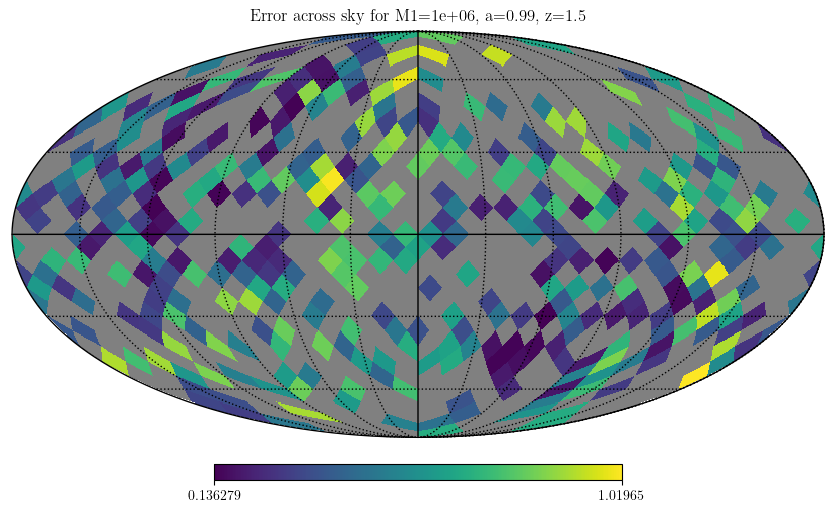

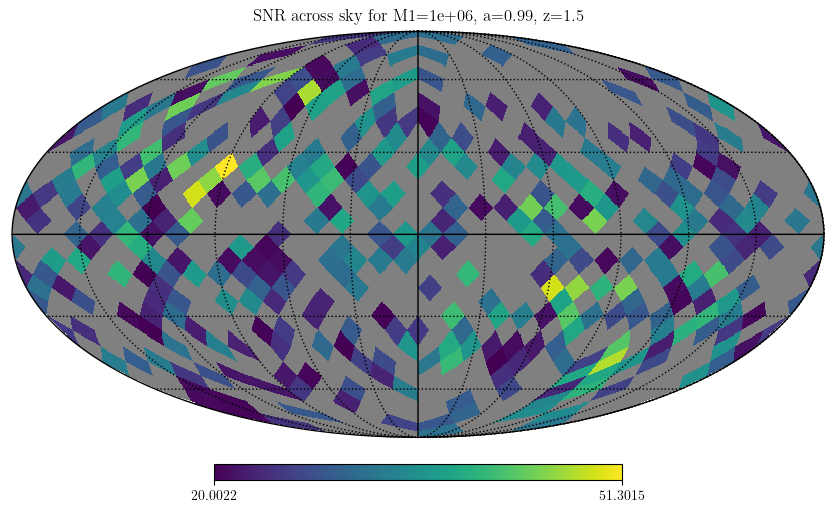

In [29]:
import healpy as hp

df_temp = pe_results[(pe_results['m1'] == 1e6) & (pe_results['a'] == 0.99) & (pe_results['redshift'] == 1.5)]
# Get the sky locations and SNR values
sky_locations = df_temp["sky_loc"].iloc[0] if len(df_temp) > 0 else []
snr_values = df_temp["snr"].iloc[0] if len(df_temp) > 0 else []
err_M = df_temp["relative_errors_M"].iloc[0] if len(df_temp) > 0 else []

# Convert sky locations to theta, phi for healpy
theta = sky_locations[:, 0]  # colatitude
phi = sky_locations[:, 1]    # azimuth

# Create a HEALPix map
nside = 8
npix = hp.nside2npix(nside)
error_map = np.full(npix, hp.UNSEEN)

# Map SNR values to pixels
pixels = hp.ang2pix(nside, theta, phi)
error_map[pixels] = err_M

# Create mollweide projection plot
hp.mollview(error_map, title=f'Error across sky for M1={1e6:.0e}, a=0.99, z=1.5', cmap='viridis')
hp.graticule()
plt.show()


# Create a HEALPix map
nside = 8
npix = hp.nside2npix(nside)
snr_map = np.full(npix, hp.UNSEEN)

# Map SNR values to pixels
pixels = hp.ang2pix(nside, theta, phi)
snr_map[pixels] = snr_values

# Create mollweide projection plot
hp.mollview(snr_map, title=f'SNR across sky for M1={1e6:.0e}, a=0.99, z=1.5', cmap='viridis')
hp.graticule()
plt.show()

(10, 2)
(10, 2)
(10, 2)


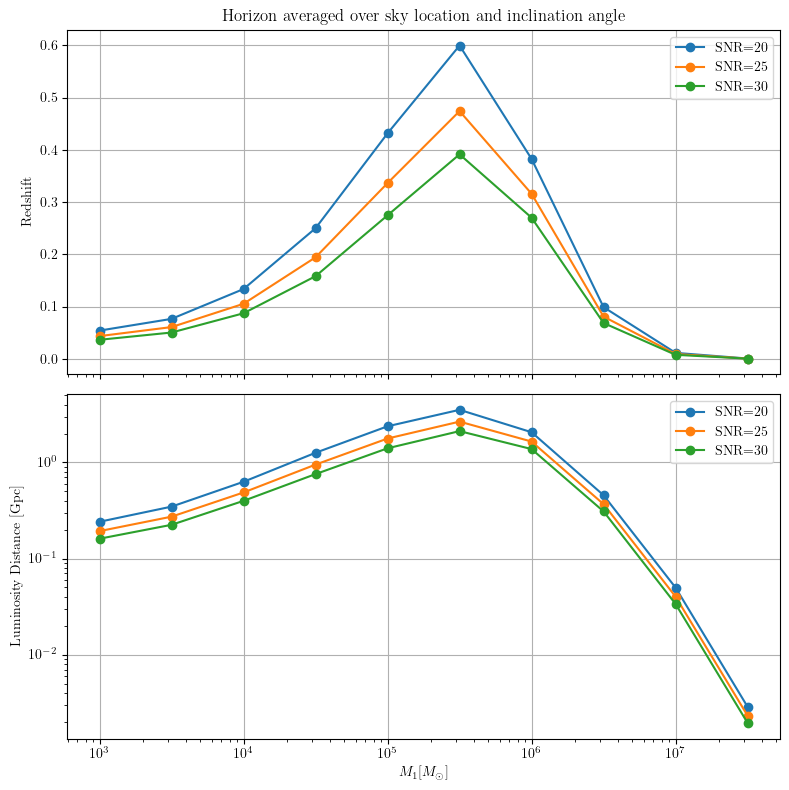

In [4]:
def get_redshift_dl_from_snr(snr=20., m1=1e3, a=0., sensitivity_factor=1.0):
    """Get redshift and luminosity distance from SNR using interpolation.

    Args:
        snr (float, optional): Signal-to-noise ratio. Defaults to 20..
        m1 (float, optional): Mass of the primary black hole. Defaults to 1e3.
        a (float, optional): Spin parameter. Defaults to 0..
        sensitivity_factor (float, optional): Sensitivity factor. Defaults to 1.0.

    Returns:
        redshift (float): Redshift corresponding to the given SNR.
        luminosity_distance (float): Luminosity distance corresponding to the given SNR.
    """
    df_temp = snr_results[(snr_results['m1'] == m1) & (snr_results['a'] == a)]
    snr_z = np.vstack(df_temp["snr"].to_numpy())/np.sqrt(sensitivity_factor)
    avg_snr = np.mean(snr_z, axis=1)
    interp_func = interp1d(np.log10(avg_snr), np.log10(df_temp["redshift"]), kind='linear', fill_value="extrapolate")
    z = 10 ** interp_func(np.log10(snr))
    lum_d = cosmo.get_luminosity_distance(z)
    return z, lum_d

snr_values = [20, 25, 30]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

for snr_val in snr_values:
    redshift_dl = np.asarray([get_redshift_dl_from_snr(snr=snr_val, m1=m1) for m1 in m1_list])
    print(redshift_dl.shape)
    redshift = redshift_dl[:, 0]
    luminosity_distance = redshift_dl[:, 1]
    ax1.semilogx(m1_list, redshift, label=f"SNR={snr_val}", marker='o')
    ax2.loglog(m1_list, luminosity_distance, label=f"SNR={snr_val}", marker='o')

ax1.set_ylabel("Redshift")
ax1.set_title("Horizon averaged over sky location and inclination angle")
ax1.grid()
ax1.legend()

ax2.set_xlabel(r"$M_1 [M_\odot]$")
ax2.set_ylabel("Luminosity Distance [Gpc]")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

In [5]:
def get_error(error_name='relative_errors_M', ef=0.01, m2=10., sensitivity_factor=1.0):
    """Get error data
    
    Args:
        error_name (str, optional): Name of the error metric to retrieve. Defaults to 'absolute_errors_M'.
        ef (float, optional): Final eccentricity value. Defaults to 0.01.
        a (float, optional): Spin parameter. Defaults to 0.
    Returns:
        err (np.ndarray): Array of error values.
        snr (np.ndarray): Corresponding SNR values.
        skyloc (np.ndarray): Corresponding sky location values."""
    df_temp = pe_results[(pe_results['m2'] == m2) & (pe_results['ef'] == ef)]
    snr = df_temp["snr"].to_numpy()[0] / np.sqrt(sensitivity_factor)
    err = df_temp[error_name].to_numpy()[0] * np.sqrt(sensitivity_factor)
    skyloc = df_temp["sky_loc"].to_numpy()[0]
    return err, snr, skyloc

In [6]:
error_names = [el for el in pe_results.keys() if "error" in el]
error_names, m2_list, ef_list

(['absolute_errors_Omega',
  'absolute_errors_a',
  'absolute_errors_dist',
  'absolute_errors_e0',
  'absolute_errors_iota',
  'absolute_errors_p0',
  'relative_errors_M',
  'relative_errors_mu'],
 array([10., 50.]),
 array([0.01, 0.05]))

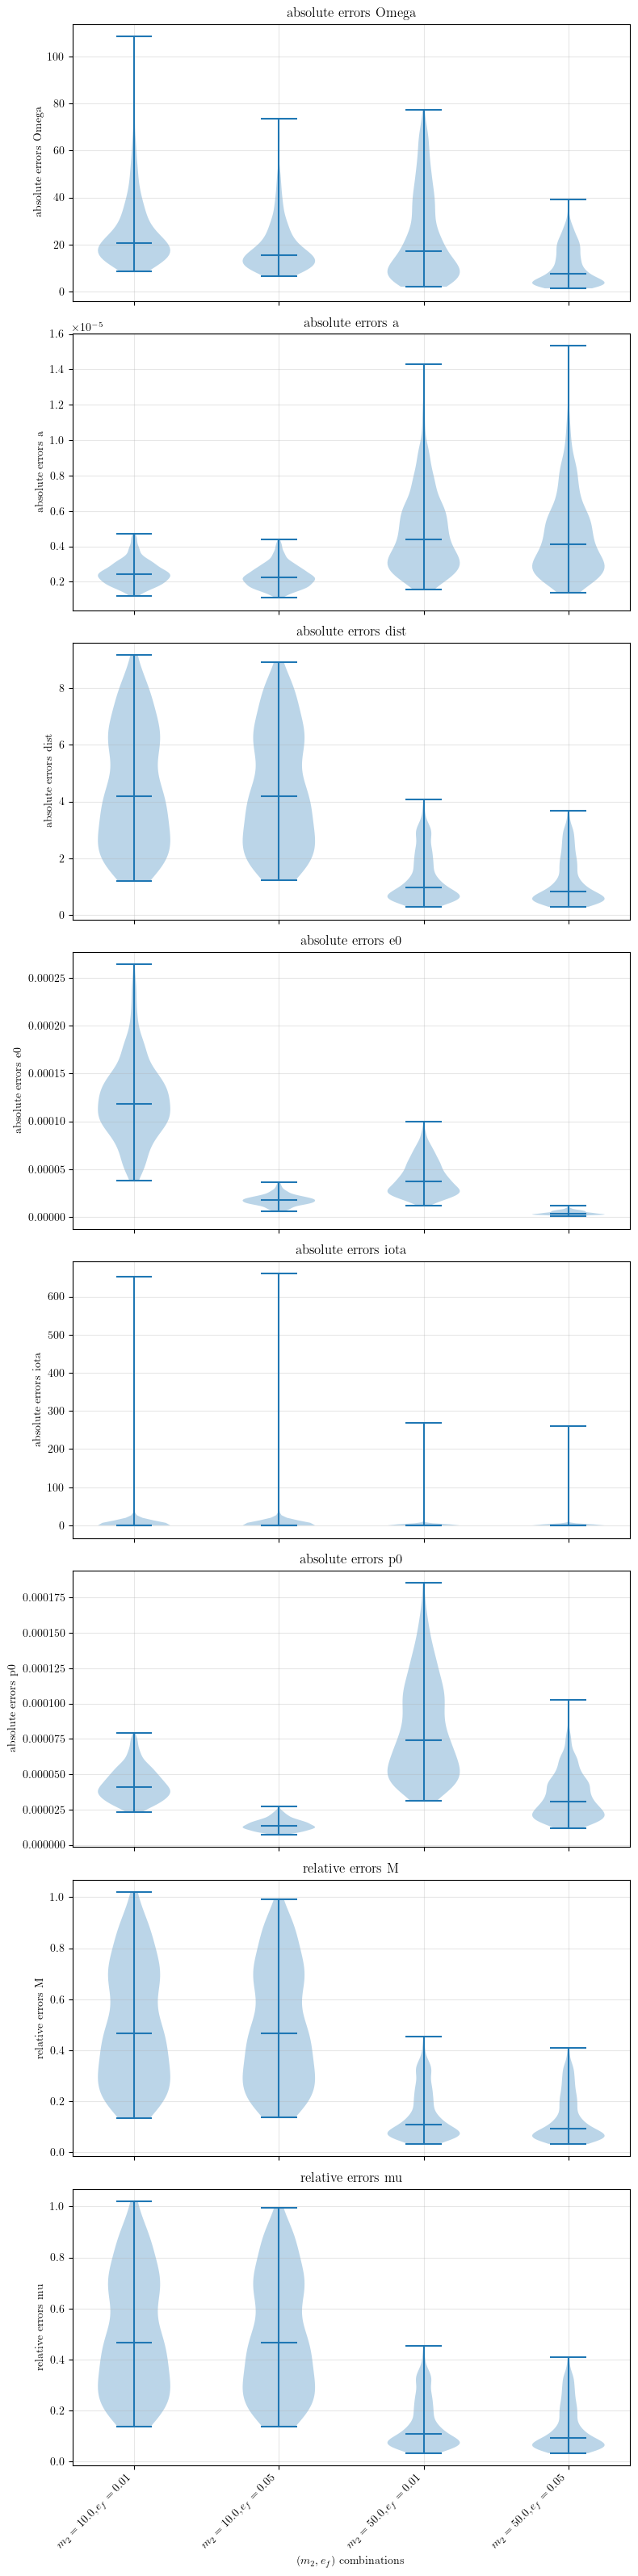

In [7]:
# Calculate number of subplots needed
n_errors = len(error_names)

fig, axes = plt.subplots(n_errors, 1, figsize=(8, 4*n_errors), sharex=True)
if n_errors == 1:
    axes = [axes]  # Make it a list for consistent indexing

# Create x-axis labels for m2 and ef combinations
x_labels = []
for m2 in m2_list:
    for ef in ef_list:
        x_labels.append(f"$m_2={m2}, e_f={ef}$")

for i, error_name in enumerate(error_names):
    ax = axes[i]
    
    # Collect all error data for violin plot
    violin_data = []
    for m2 in m2_list:
        for ef in ef_list:
            err, snr_data, skyloc = get_error(error_name=error_name, ef=ef, m2=m2)
            violin_data.append(err)
    
    # Create violin plot
    violin_parts = ax.violinplot(violin_data, positions=range(len(violin_data)), showmeans=False, showmedians=True)
    
    ax.set_ylabel(error_name.replace('_', ' '))
    ax.set_title(f'{error_name.replace("_", " ")}')
    ax.grid(True, alpha=0.3)

# Set x-axis labels only on the bottom subplot
axes[-1].set_xlabel('$(m_2, e_f)$ combinations')
axes[-1].set_xticks(range(len(x_labels)))
axes[-1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()


In [8]:
# fixed
snr_evaluation = 20.
snr_threshold = 20.0

labels = ["$1<d<1.5$", "$1.5<d<2$", "$d>2$"]
snr_labels = [(1.0, "green", labels[0]), (1.5, "yellow", labels[1]), (2.0, "red", labels[2])]

# how to create a redshift based requirement
with h5py.File("snr_requirements_summary.h5", "w") as hf:
    for fact, color, _ in snr_labels:
        grp = hf.create_group(color)
        requirement_ = {float(a): np.hstack((m1_list[:, np.newaxis], np.asarray([get_redshift_dl_from_snr(snr=snr_threshold, m1=m1, a=a, sensitivity_factor=fact) for m1 in m1_list]))) for a in np.unique(snr_results["a"].to_numpy())}
        for a_val, arr in requirement_.items():
            dset = grp.create_dataset(f"a_{a_val}", data=arr)
            dset.attrs["columns"] = np.array(["m1 (source frame primary mass in solar masses)", "redshift (averaged over sky location and inclination angle)", "luminosity distance (averaged over sky location and inclination angle in Gpc)"], dtype="S")
        grp.attrs["description"] = f"Results for SNR={snr}, color={color}"
    hf.attrs["info"] = "Each group contains datasets for the redshift requirement at a given SNR threshold."

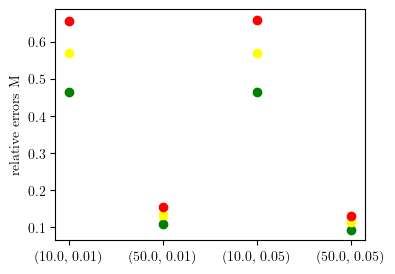

In [9]:
index_plot = -2  # Change this index to plot different error metrics
# inference requirement
with h5py.File("inference_requirements_summary.h5", "w") as hf:
    plt.figure()
    for fact, color, _ in snr_labels:
        grp = hf.create_group(color)
        requirement_ = {}
        for ef in ef_list:
            for m2 in m2_list:
                requirement_[(float(m2), float(ef))] = np.asarray([np.median(get_error(error_name=error_name, ef=ef, m2=m2, sensitivity_factor=fact)[0]) for error_name in error_names])
        [plt.plot(str(key), item[index_plot], 'o', color=color) for key, item in requirement_.items()]
        plt.ylabel(error_names[index_plot].replace('_', ' '))
        for m2_ef, arr in requirement_.items():
            dset = grp.create_dataset(f"m2_{m2_ef[0]}_ef_{m2_ef[1]}", data=arr)
            dset.attrs["columns"] = np.array(error_names, dtype="S")
        grp.attrs["description"] = f"Results for relative error in primary mass, color={color}"
    hf.attrs["info"] = "Each group contains datasets for the relative error requirement at a given SNR threshold."

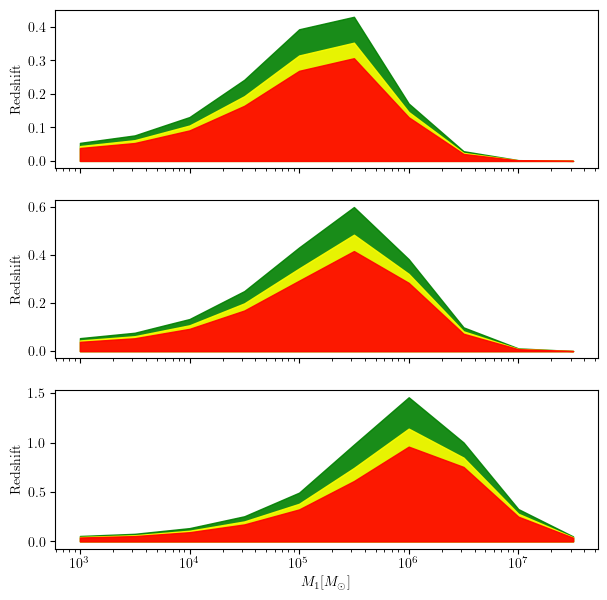

In [10]:
with h5py.File("snr_requirements_summary.h5", "r") as hf:
    spins = [-0.99, 0.0, 0.99]
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for idx, spin in enumerate(spins):
        ax = axes[idx]
        list_z = []
        # requirements
        for snr, color, ll in snr_labels:
            grp = hf[color]
            arr = grp[f"a_{spin}"][:]
            m1_vals = arr[:, 0]
            z_vals = arr[:, 1]
            list_z.append(z_vals)
        
            ax.fill_between(m1_vals, z_vals, alpha=0.9, color=color, label=ll)
        example_ = np.asarray(list_z)
        ax.set_xscale("log")
        ax.set_ylabel("Redshift")
    axes[-1].set_xlabel(r"$M_1 [M_\odot]$")


In [11]:
error_names

['absolute_errors_Omega',
 'absolute_errors_a',
 'absolute_errors_dist',
 'absolute_errors_e0',
 'absolute_errors_iota',
 'absolute_errors_p0',
 'relative_errors_M',
 'relative_errors_mu']

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\%'
<>:89: SyntaxWarning: invalid escape sequence '\o'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:80: SyntaxWarning: invalid escape sequence '\%'
<>:89: SyntaxWarning: invalid escape sequence '\o'
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_94711/1424040389.py:12: SyntaxWarning: invalid escape sequence '\s'
  'relative_errors_M': '$\sigma[m_2]/m_1$',
/var/folders/

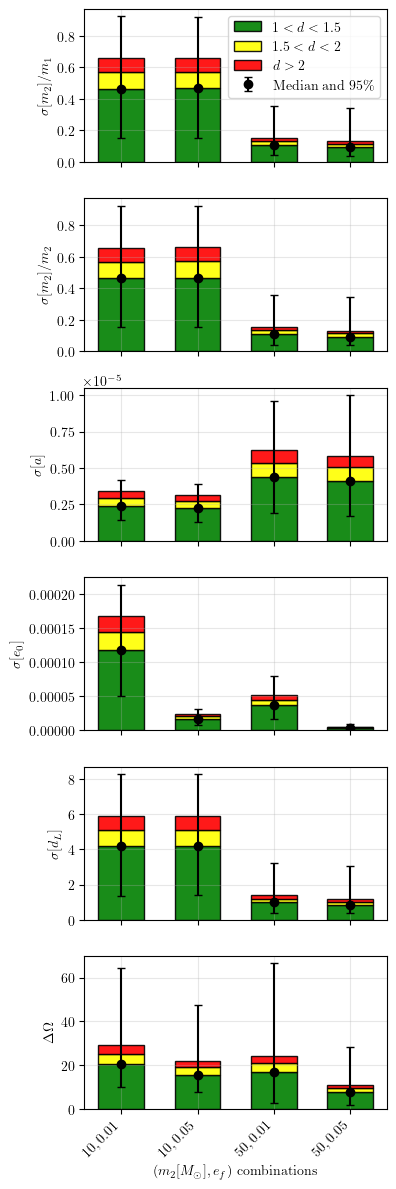

In [18]:
with h5py.File("inference_requirements_summary.h5", "r") as hf:
    # Force desired error order and labels: only M and mu are relative, others are absolute
    desired_order = [
        'relative_errors_M',
        'relative_errors_mu',
        'absolute_errors_a',
        'absolute_errors_e0',
        'absolute_errors_dist',
        'absolute_errors_Omega'
    ]
    label_map = {
        'relative_errors_M': '$\sigma[m_2]/m_1$',
        'relative_errors_mu': '$\sigma[m_2]/m_2$',
        'absolute_errors_a': '$\sigma[a]$',
        'absolute_errors_e0': '$\sigma[e_0]$',
        'absolute_errors_dist': '$\sigma[d_L]$',
        'absolute_errors_Omega': '$\Delta \Omega$'
    }

    # Keep only those requested that actually exist in the data
    plot_error_names = [name for name in desired_order if name in error_names]

    fig, axes = plt.subplots(len(plot_error_names), 1, figsize=(4, 12), sharex=True)
    if len(plot_error_names) == 1:
        axes = [axes]

    # Create x-axis labels for m2 and ef combinations
    x_labels = []
    for m2 in m2_list:
        for ef in ef_list:
            x_labels.append(f"${int(m2)},{ef}$")

    for i, error_name in enumerate(plot_error_names):
        ax = axes[i]

        # Collect data for each degradation factor
        positions = list(range(len(x_labels)))
        bar_data = {color: [] for _, color, _ in snr_labels}
        violin_data = []

        for m2 in m2_list:
            for ef in ef_list:
                err, snr_data, skyloc = get_error(error_name=error_name, ef=ef, m2=m2)
                # Ensure we have a 1d numpy array for violin plotting
                violin_data.append(np.asarray(err).ravel())
                for fact, color, _ in snr_labels:
                    grp = hf[color]
                    arr = grp[f"m2_{m2}_ef_{ef}"][:]
                    error_idx = error_names.index(error_name)
                    bar_data[color].append(arr[error_idx])

        # Convert bar_data lists to numpy arrays for vector ops
        for color in bar_data:
            bar_data[color] = np.asarray(bar_data[color], dtype=float)

        # Plot bars as ranges between regions: each bar for a color spans from the previous
        # region's value up to that color's value (so bars don't all start at zero).
        width = 0.6
        prev_values = np.zeros(len(positions), dtype=float)
        for fact, color, label in snr_labels:
            values = bar_data[color]
            heights = values - prev_values
            # Use bottom=prev_values so each bar starts where the previous region ended
            ax.bar(positions, heights, width, bottom=prev_values, label=label, color=color, alpha=0.9, edgecolor='k')
            prev_values = values

        # Prepare violin plot data, replace empty arrays with NaN so matplotlib doesn't crash
        violin_plot_data = [v if v.size > 0 else np.array([np.nan]) for v in violin_data]
        # Plot violin plots centered on the integer positions
        # ax.violinplot(violin_plot_data, positions=positions, showmeans=False, showmedians=False)

        # Compute median and asymmetric 95% CI for each violin
        q95 = [np.percentile(v, (2.5, 50, 97.5)) if (v.size > 0 and not np.all(np.isnan(v))) else (np.nan, np.nan, np.nan) for v in violin_plot_data]
        medians = np.array([q[1] for q in q95], dtype=float)
        lower_err = medians - np.array([q[0] for q in q95], dtype=float)
        upper_err = np.array([q[2] for q in q95], dtype=float) - medians
        lower_err = np.nan_to_num(lower_err)
        upper_err = np.nan_to_num(upper_err)
        yerr = np.vstack((lower_err, upper_err))
        ax.errorbar(positions, medians, yerr=yerr, fmt='ko', capsize=3, label='Median and $95\%$')

        # Use the simplified y-labels requested (map M->m1, mu->m2)
        ax.set_ylabel(label_map.get(error_name, error_name.replace('_', ' ')))
        # Titles removed as requested
        ax.grid(True, alpha=0.3)
    axes[0].legend()

    # Set x-axis labels only on the bottom subplot
    axes[-1].set_xlabel('$(m_2[M_\odot], e_f)$ combinations')
    axes[-1].set_xticks(positions)
    axes[-1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)

    plt.tight_layout()
    plt.savefig(f"pe_requirements.png", dpi=300)
    plt.show()


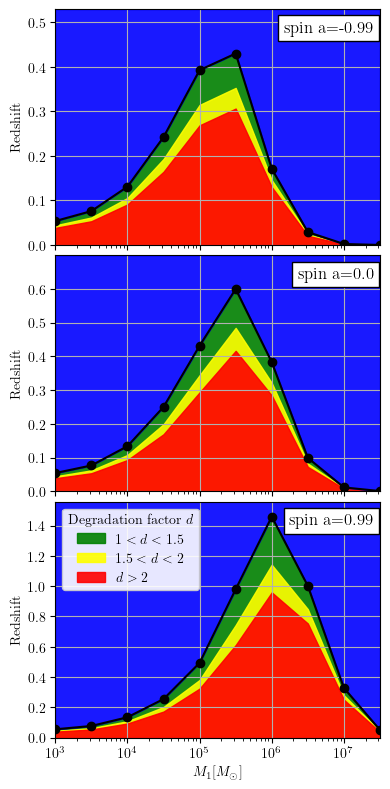

In [13]:
json_data = {}
with h5py.File("snr_requirements_summary.h5", "r") as hf:
    spin = 0.0
    spins = [-0.99, 0.0, 0.99]
    fig, axes = plt.subplots(3, 1, figsize=(4, 8), sharex=True)
    for idx, spin in enumerate(spins):
        ax = axes[idx]
        # current evaluation
        redshift_dl = np.asarray([get_redshift_dl_from_snr(snr=snr_evaluation, m1=m1, a=spin) for m1 in m1_list])
        redshift = redshift_dl[:, 0]
        ax.semilogx(m1_list, redshift, color='k', marker='o')#, label=r'Degradation factor $d = 1$')
        
        list_z = []
        # requirements
        for snr, color, ll in snr_labels:
            grp = hf[color]
            arr = grp[f"a_{spin}"][:]
            m1_vals = arr[:, 0]
            z_vals = arr[:, 1]
            # ax.semilogx(m1_vals, z_vals, label=ll, color=color)
            ax.fill_between(m1_vals, z_vals, alpha=0.9, color=color, label=ll)
            # check if redshift in z_vals
            # print(color, "is horizon redshift above? ",np.sum(redshift<z_vals)==0)
            list_z.append(z_vals)
        
        example_ = np.asarray(list_z)
        # print(get_redshift_range(redshift, example_))
        
        # blue
        ax.set_xscale("log")
        arr_red = hf["green"][f"a_{spin}"][:]
        m1_vals_red = arr_red[:, 0]
        z_vals_red = np.zeros_like(arr_red[:, 1]) + arr_red[:, 1].max() + 0.1
        ax.fill_between(m1_vals_red, arr_red[:, 1], z_vals_red, alpha=0.9, color="blue")#, label= "SNR$<$"+str(snr_ranges[0]))


        ax.text(0.98, 0.95, f"spin a={spin}", transform=ax.transAxes, fontsize=12, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=1.0, ))# edgecolor='none'
        ax.grid()
        if idx == 2:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.9, title="Degradation factor $d$")
        ax.set_ylim(0, arr_red[:, 1].max() + 0.1)
        ax.set_xlim(m1_list.min(), m1_list.max())
        # Store results for each spin in the json_data dictionary
        json_data[str(spin)] = {
            "m1": m1_list.tolist(),
            "redshift": redshift.tolist()
        }
    # axes[0].set_title(f"Requirement for redshift horizon with SNR={snr_evaluation}")
    axes[-1].set_xlabel(r"$M_1 [M_\odot]$")
    for ax in axes:
        ax.set_ylabel("Redshift")
    plt.tight_layout(h_pad=0.2)
    plt.savefig(f"snr_redshift_requirement_allspins.png", dpi=300)

# Fake a sensitivity reduction
We want to understand how much freedom we are giving to the overall sensitivity. We assume a factor of 2 larger noise floor power spectral density $S_n(f)\rightarrow 2 S_n(f)$ leads to an SNR reduction of SNR$\rightarrow$SNR$/\sqrt{2}$

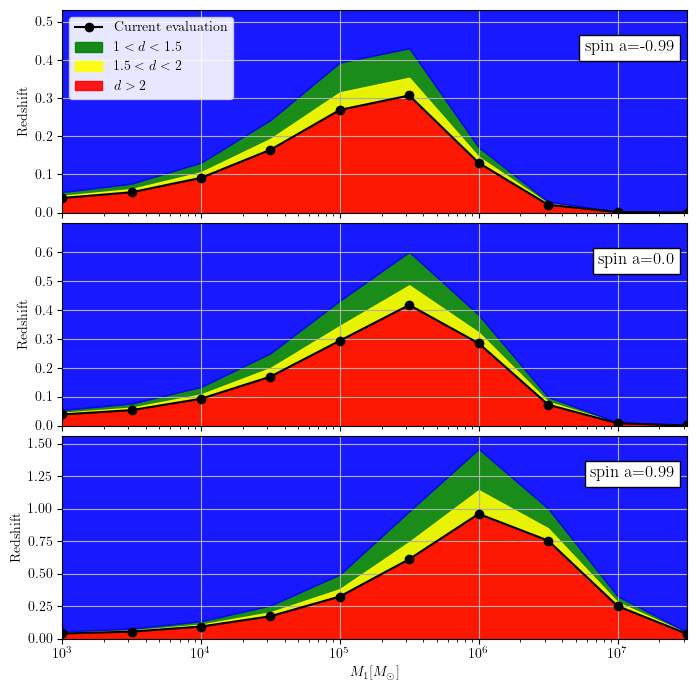

In [14]:
simulated_degradation_factor = 2.0
json_data = {}
with h5py.File("snr_requirements_summary.h5", "r") as hf:
    spin = 0.0
    spins = [-0.99, 0.0, 0.99]
    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)
    for idx, spin in enumerate(spins):
        ax = axes[idx]
        # current evaluation
        redshift_dl = np.asarray([get_redshift_dl_from_snr(snr=snr_evaluation, m1=m1, a=spin, sensitivity_factor=simulated_degradation_factor) for m1 in m1_list])
        redshift = redshift_dl[:, 0]
        ax.semilogx(m1_list, redshift, color='k', marker='o', label='Current evaluation')
        
        # requirements
        for snr, color, ll in snr_labels:
            grp = hf[color]
            arr = grp[f"a_{spin}"][:]
            m1_vals = arr[:, 0]
            z_vals = arr[:, 1]
            # ax.semilogx(m1_vals, z_vals, label=ll, color=color)
            ax.fill_between(m1_vals, z_vals, alpha=0.9, color=color, label=ll)
        
        arr_red = hf["green"][f"a_{spin}"][:]
        m1_vals_red = arr_red[:, 0]
        z_vals_red = np.zeros_like(arr_red[:, 1]) + arr_red[:, 1].max() + 0.1
        ax.fill_between(m1_vals_red, arr_red[:, 1], z_vals_red, alpha=0.9, color="blue")
        # ax.set_yscale("log")
        ax.text(0.98, 0.85, f"spin a={spin}", transform=ax.transAxes, fontsize=12, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=1.0, ))# edgecolor='none'
        ax.grid()
        if idx == 0:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
        ax.set_ylim(0, arr_red[:, 1].max() + 0.1)
        ax.set_xlim(m1_list.min(), m1_list.max())
        # Store results for each spin in the json_data dictionary
        json_data[str(spin)] = {
            "m1": m1_list.tolist(),
            "redshift": redshift.tolist()
        }
    # axes[0].set_title(f"Requirement for redshift horizon with SNR={snr_evaluation}")
    axes[-1].set_xlabel(r"$M_1 [M_\odot]$")
    for ax in axes:
        ax.set_ylabel("Redshift")
    plt.tight_layout(h_pad=0.2)

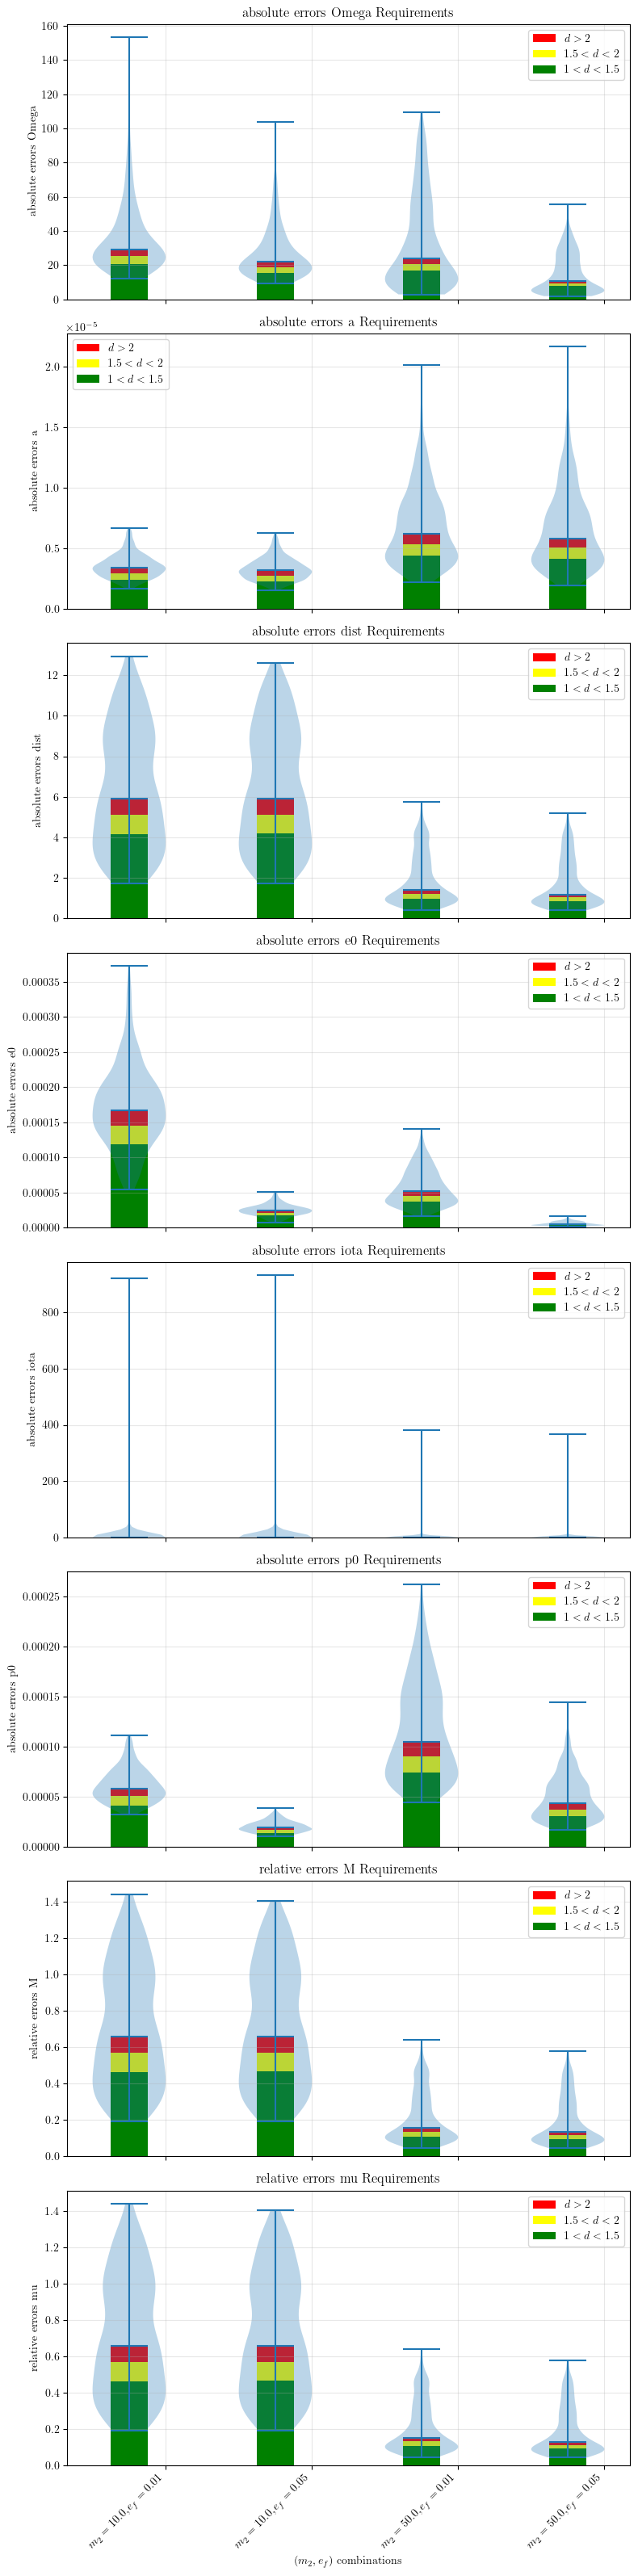

In [15]:
with h5py.File("inference_requirements_summary.h5", "r") as hf:
    fig, axes = plt.subplots(len(error_names), 1, figsize=(8, 4*len(error_names)), sharex=True)
    if len(error_names) == 1:
        axes = [axes]
    
    # Create x-axis labels for m2 and ef combinations
    x_labels = []
    for m2 in m2_list:
        for ef in ef_list:
            x_labels.append(f"$m_2={m2}, e_f={ef}$")
    
    for i, error_name in enumerate(error_names):
        ax = axes[i]
        
        # Collect data for each degradation factor
        positions = list(range(len(x_labels)))
        bar_data = {color: [] for _, color, _ in snr_labels}
        violin_data = []
        
        for m2 in m2_list:
            for ef in ef_list:
                err, snr_data, skyloc = get_error(error_name=error_name, ef=ef, m2=m2, sensitivity_factor=simulated_degradation_factor)
                violin_data.append(err)
                for fact, color, _ in snr_labels:
                    grp = hf[color]
                    arr = grp[f"m2_{m2}_ef_{ef}"][:]
                    error_idx = error_names.index(error_name)
                    bar_data[color].append(arr[error_idx])
        
        # Create grouped bars to show ranges
        width = 0.25
        last_bar = np.zeros(len(x_labels))
        for j, (fact, color, label) in enumerate(snr_labels[::-1]):
            x_pos = [pos + 0 * j * width for pos in positions]

            ax.bar(x_pos, bar_data[color], width, label=label, color=color, alpha=1.0)
        
        # remove violin plot
        ax.violinplot(violin_data, positions=range(len(violin_data)), showmeans=False, showmedians=True)
        
        ax.set_ylabel(error_name.replace('_', ' '))
        ax.set_title(f'{error_name.replace("_", " ")} Requirements')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    # Set x-axis labels only on the bottom subplot
    axes[-1].set_xlabel('$(m_2, e_f)$ combinations')
    axes[-1].set_xticks([pos + width for pos in positions])
    axes[-1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
